In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from io import StringIO, BytesIO
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display
import os


if not os.path.exists('../data'):
    raise Exception('Missing ../data/bus_area_income.csv xor ../data/tl_2019_25_tract.shp')
    
np.random.seed(7)

RTA_ROUTE_URL = 'https://opendata.arcgis.com/datasets/1cb5c63d6f114f8a94c6d5a0e03ae62e_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
RTA_ROUTE_DATA = requests.get(RTA_ROUTE_URL)

RTA_STOPS_URL = 'https://gis.massdot.state.ma.us/arcgis/rest/services/Multimodal/RTAs/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json'
RTA_STOPS_DATA = requests.get(RTA_STOPS_URL)

RTA_RIDERSHIP_URL = 'https://www.transit.dot.gov/sites/fta.dot.gov/files/2020-10/August%202020%20Adjusted%20Database.xlsx'
RTA_RIDERSHIP_DATA = requests.get(RTA_RIDERSHIP_URL)

# mapping agencies between datasets
stops2ridership = {
    'VineyardRTA': "Woods Hole, Martha's Vineyard and Nantucket Steamship Authority",
    'CapeCodRTA': "Cape Cod Regional Transit Authority",
    'LowellRTA': 'Lowell Regional Transit Authority',
    'CapeAnnRTA': "Cape Ann Transportation Authority",
    'BerkshireRTA': "Berkshire Regional Transit Authority",
    'MontachusettRTA': "Montachusett Regional Transit Authority",
    'MerrimackValleyRTA': "Merrimack Valley Regional Transit Authority",
    'PioneerValleyRTA': 'Pioneer Valley Transit Authority',
    'MetroWestRTA': 'MetroWest Regional Transit Authority',
    'WRTA': 'Worcester Regional Transit Authority COA',
    'BrocktonAreaRTA': 'Brockton Area Transit Authority'
}

# Rishab helper code
def add_census_tract(dataframe):
    polygons = gpd.read_file("../data/tl_2019_25_tract.shp")
    polygons = polygons.rename(columns={"TRACTCE": "census_tract"}, index=str)
    polygons = polygons.to_crs("EPSG:4326")
    gdf = dataframe
    df = gpd.sjoin(gdf, polygons[['census_tract', 'geometry']], how='left', op='within')
    df.drop(columns=['index_right'], inplace=True)
    return df


def get_median_hh_income():
    '''
    Returns Pandas DataFrame representation Median Household Income Estimate by Census Tract for MA.
    American Community Survey (ACS) 2018 Census data used.
    Specific table: ACS 2018 5-year detailed table "B19013_001E"
    '''
    URL = "https://api.census.gov/data/2018/acs/acs5?get=B19013_001E&for=tract:*&in=state:25"

    response = requests.get(url = URL)
    data = response.json()

    median_income_df = pd.DataFrame(data[1:len(data)-1], columns = data[0])

    return median_income_df


def bus_stops_median_household_income(stops_data):
    '''
    Adds household median income to stops data
    '''
    if os.path.exists('../data/bus_area_income_df.csv'):
        return pd.read_csv('../data/bus_area_income.csv')
    
    try:
        stops_data_parsed = []
        for stop in stops_data:
            stop_reformatted = {}
            stop_reformatted['geometry'] = stop['geometry']
            for key in stop['attributes']:
                stop_reformatted[key] = stop['attributes'][key]
            stops_data_parsed.append(stop_reformatted)
        gdf = gpd.GeoDataFrame(stops_data_parsed)
        df = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(
            [stop['geometry']['x'] for stop in stops_data], 
            [stop['geometry']['y'] for stop in stops_data], crs='EPSG:4326')
        )
        census_df = add_census_tract(df)
        return census_df.join(
            get_median_hh_income().set_index('tract'), 
            on='census_tract'
        ).rename(columns={'B19013_001E': 'median_household_income'})
    except:
        raise Exception('You probably need to install rtree or have local file ../data/bus_area_income.csv!')

def get_population():
    '''
    Returns Pandas DataFrame representation Unweighted Sample Count of the Population by Census Tract for MA.
    American Community Survey (ACS) 2018 Census data used.
    Specific table: ACS 2018 5-year detailed table "B00001_001E"
    '''
    URL = "https://api.census.gov/data/2018/acs/acs5?get=B00001_001E&for=tract:*&in=state:25"
    response = requests.get(url = URL)
    data = response.json()

    population_df = pd.DataFrame(data[1:len(data)-1], columns = data[0])

    return population_df

# DATAFRAMES

`route_df` is a dataframe containing routes from all RTA's throughout MA

`ridership_df` is a dataframe containing ridership and fare data for all RTA's

`bus_area_income_df` is a dataframe containing RTA bus stop data with data on the median household income of the bus stops location

`population_df` is a dataframe containing population for each census tract

`bus_route_stop_mapped_df` is a dataframe containing geospatially thresholded bus stops mapped onto routes

In [2]:
# Transit Datasets
route_df = pd.read_csv(StringIO(RTA_ROUTE_DATA.content.decode()))
stops_data = json.loads(RTA_STOPS_DATA.content)['features']

ridership_df = pd.read_excel(BytesIO(RTA_RIDERSHIP_DATA.content), sheet_name='MASTER')
ridership_df = ridership_df[ridership_df.Mode == 'MB'] # only buses
ridership_df = ridership_df[ridership_df['HQ State'] == 'MA'] # only buses

bus_area_income_df = bus_stops_median_household_income(stops_data)
population_df = get_population().drop(columns=['state', 'county'])

population_data = np.array(requests.get(
    "https://api.census.gov/data/2018/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,GEONAME,STATE&for=county:*&in=state:25"
).json())
population_headers = population_data[0].tolist()
population_data = population_data[1:]

# Population data based on county
county_population_df = pd.DataFrame(
    {header: population_data[:, population_headers.index(header)] for header in population_headers}
).drop(columns=['state', 'county'])

# Get only 2018 population estimates
county_population_df = county_population_df.loc[county_population_df['DATE_DESC'] == '7/1/2018 population estimate']

population_df = get_population().drop(columns=['state', 'county'])
stops2routes_df = pd.read_csv('../data/result.csv')

result = pd.read_csv('../data/result.csv')
if 'Unnamed: 0' in result.columns:
    result = result.drop(columns=['Unnamed: 0']).drop_duplicates()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# join population_df to bus_area_income_df
bus_area_income_df = pd.merge(bus_area_income_df, population_df, how='inner', left_on='census_tract', right_on='tract')

In [4]:
# TODO: Verify this has all the MA rta's
ma_riders = ridership_df.loc[ridership_df['UZA Name'].str.contains(', MA')]
ma_riders = ma_riders.loc[ma_riders['Agency'] != 'Massachusetts Bay Transportation Authority']
agency_set = list(set([stop['attributes']['Agency'] for stop in stops_data]))

In [5]:
# Clean data

# drop negative income data
bus_area_income_df['median_household_income'] = bus_area_income_df['median_household_income'].astype(float)
bus_area_income_df = bus_area_income_df[bus_area_income_df.median_household_income > 0] 
bus_area_income_df.dropna()

# rename population column
bus_area_income_df = bus_area_income_df.rename(columns={"B00001_001E": "population"})

# drop duplicate bus stops
print(len(bus_area_income_df.index))
bus_area_income_df = bus_area_income_df.drop_duplicates(subset=['stop_id'])
print(len(bus_area_income_df.index))

# drop unnecessary columns
bus_area_income_df = bus_area_income_df.drop(columns=['platform_code', 'zone_id', 'stop_timezone', 'position', 'direction', 'state', 'stop_desc'])
route_df = route_df.drop(columns=['route_desc', 'route_color', 'route_text_color', 'route_sort_order', 'min_headway_minutes', 'eligibility_restricted', 'continuous_pickup', 'continuous_drop_off', 'route_type_text'])

8987
8134


## ROUTE

In [6]:
display(route_df.head())

,OBJECTID,shape_id,agency_id,route_id,route_short_name,route_long_name,route_type,route_url,Agency,ShapeSTLength
0,1,p_6097,444,2933,1,Montello Street Via North Main Street,3,http://www.ridebat.com/schedulemaps/brockton/r1/,BrocktonAreaRTA,0.063724
1,2,p_6101,444,2934,2,S Plaza/Campello Via Main Street,3,http://www.ridebat.com/schedulemaps/brockton/r2/,BrocktonAreaRTA,0.047798
2,3,p_6102,444,2935,3,VA Hospital via Belmont,3,http://www.ridebat.com/schedulemaps/brockton/r3/,BrocktonAreaRTA,0.042324
3,4,p_6103,444,2935,3,VA Hospital via Belmont,3,http://www.ridebat.com/schedulemaps/brockton/r3/,BrocktonAreaRTA,0.057318
4,5,p_6105,444,2940,8,Southfield via Warren & Plain Street,3,http://www.ridebat.com/schedulemaps/brockton/r8/,BrocktonAreaRTA,0.091772


## RIDERSHIP

In [7]:
display(ridership_df.head())

,5 digit NTD ID,4 digit NTD ID,Agency,Mode,TOS,Active,Reporter Type,HQ City,HQ State,UZA,...,Most Recent Report Year,FY End Month,FY End Year,Passenger Miles FY,Unlinked Passenger Trips FY,Average Trip Length FY,Fares FY,Operating Expenses FY,Average Cost per Trip FY,Average Fares per Trip FY
151,10003,1003,Massachusetts Bay Transportation Authority,MB,DO,Active,Full Reporter,Boston,MA,10,...,2019.0,6.0,2019.0,255494460.0,99301293.0,2.5729,96518545.0,424586999.0,4.2757,0.9720
152,10003,1003,Massachusetts Bay Transportation Authority,MB,PT,Active,Full Reporter,Boston,MA,10,...,2019.0,6.0,2019.0,2162081.0,951692.0,2.2718,85258.0,5562842.0,5.8452,0.0896
156,10004,1004,Brockton Area Transit Authority,MB,PT,Active,Full Reporter,Brockton,MA,10,...,2019.0,6.0,2019.0,17731983.0,2636726.0,6.7250,2668996.0,11706738.0,4.4399,1.0122
159,10005,1005,Lowell Regional Transit Authority,MB,DO,Active,Full Reporter,Lowell,MA,10,...,2019.0,6.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,10005,1005,Lowell Regional Transit Authority,MB,PT,Active,Full Reporter,Lowell,MA,10,...,2019.0,6.0,2019.0,6620433.0,1370690.0,4.8300,1324536.0,9830939.0,7.1723,0.9663


## BUS STOPS WITH MEDIAN HOUSEHOLD INCOME AND POPULATION

In [8]:
display(bus_area_income_df.head())

,geometry,OBJECTID,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding,Agency,census_tract,median_household_income,county,population,tract
0,POINT (-71.05218 42.09394),1,2537977,810.0,Market Basket,42.093942,-71.052178,None,0,None,0,BrocktonAreaRTA,510502,30553.0,023,250,510502
1,POINT (-71.03735 42.09083),4,2558592,824.0,Belair St at Colonel Bell Drive,42.090826,-71.037350,None,0,None,0,BrocktonAreaRTA,510502,30553.0,023,250,510502
2,POINT (-71.03764 42.09187),5,2558593,None,Belair St at Belair Hi Rise,42.091874,-71.037641,None,0,None,0,BrocktonAreaRTA,510502,30553.0,023,250,510502
3,POINT (-71.03753 42.09189),6,2558594,821.0,Belair St at Belair Hi Rise,42.091892,-71.037535,None,0,None,0,BrocktonAreaRTA,510502,30553.0,023,250,510502
4,POINT (-71.03797 42.09337),7,2558595,None,Belair St at Earle St,42.093367,-71.037970,None,0,None,0,BrocktonAreaRTA,510502,30553.0,023,250,510502


# Population data 

In [9]:
display(county_population_df)

,COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,GEONAME,STATE
10,001,11,7/1/2018 population estimate,541.34269522,213413,"Barnstable County, Massachusetts",25
21,003,11,7/1/2018 population estimate,136.316072,126348,"Berkshire County, Massachusetts",25
32,005,11,7/1/2018 population estimate,1019.736518,564022,"Bristol County, Massachusetts",25
43,007,11,7/1/2018 population estimate,168.13085908,17352,"Dukes County, Massachusetts",25
54,009,11,7/1/2018 population estimate,1605.4399507,790638,"Essex County, Massachusetts",25
65,011,11,7/1/2018 population estimate,101.48837715,70963,"Franklin County, Massachusetts",25
76,013,11,7/1/2018 population estimate,762.42077911,470406,"Hampden County, Massachusetts",25
87,015,11,7/1/2018 population estimate,306.04129703,161355,"Hampshire County, Massachusetts",25
98,017,11,7/1/2018 population estimate,1974.3630351,1614714,"Middlesex County, Massachusetts",25
109,019,11,7/1/2018 population estimate,245.51762798,11327,"Nantucket County, Massachusetts",25


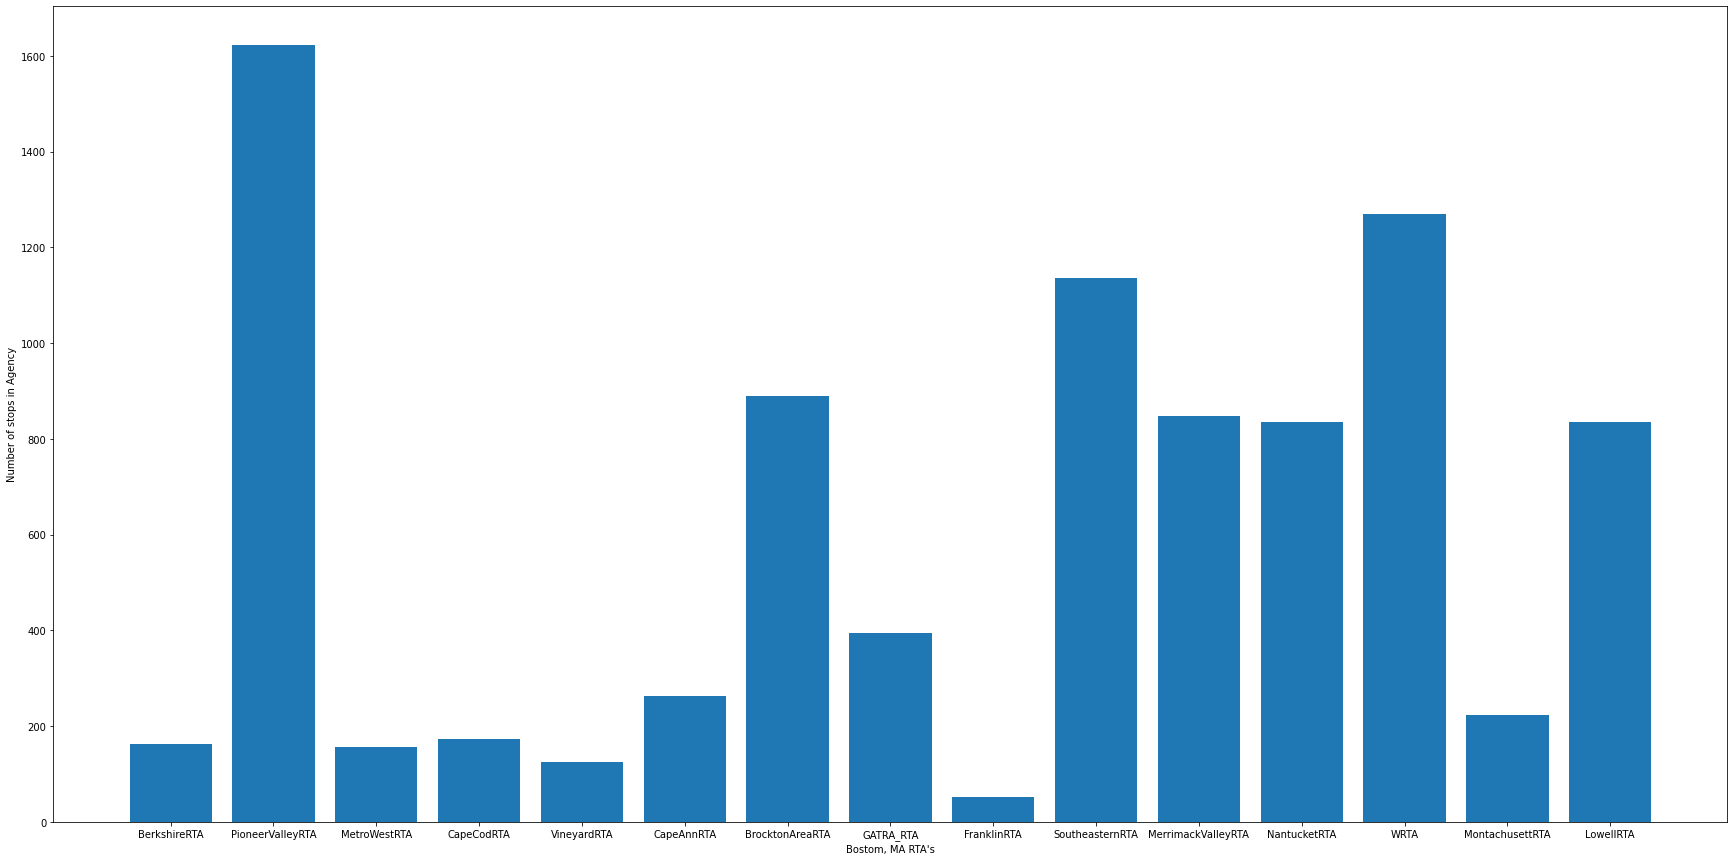

In [10]:
# Generate Bar graph of stops
num_stops = [0 for agency in agency_set]
for stop in stops_data:
    num_stops[agency_set.index(stop['attributes']['Agency'])] += 1

fig = plt.figure(figsize=(30,15))
plt.bar(agency_set, num_stops)
plt.xlabel("Bostom, MA RTA's")
plt.ylabel("Number of stops in Agency")
plt.show()

In [11]:
# Display fare income per area
agency_fares = ma_riders[['Agency']].drop_duplicates()
agency_fares[['total fare']] = agency_fares.apply(
    lambda x: ma_riders.loc[ma_riders['Agency'] == x['Agency']][['Fares FY']].sum(), 
    axis=1
)

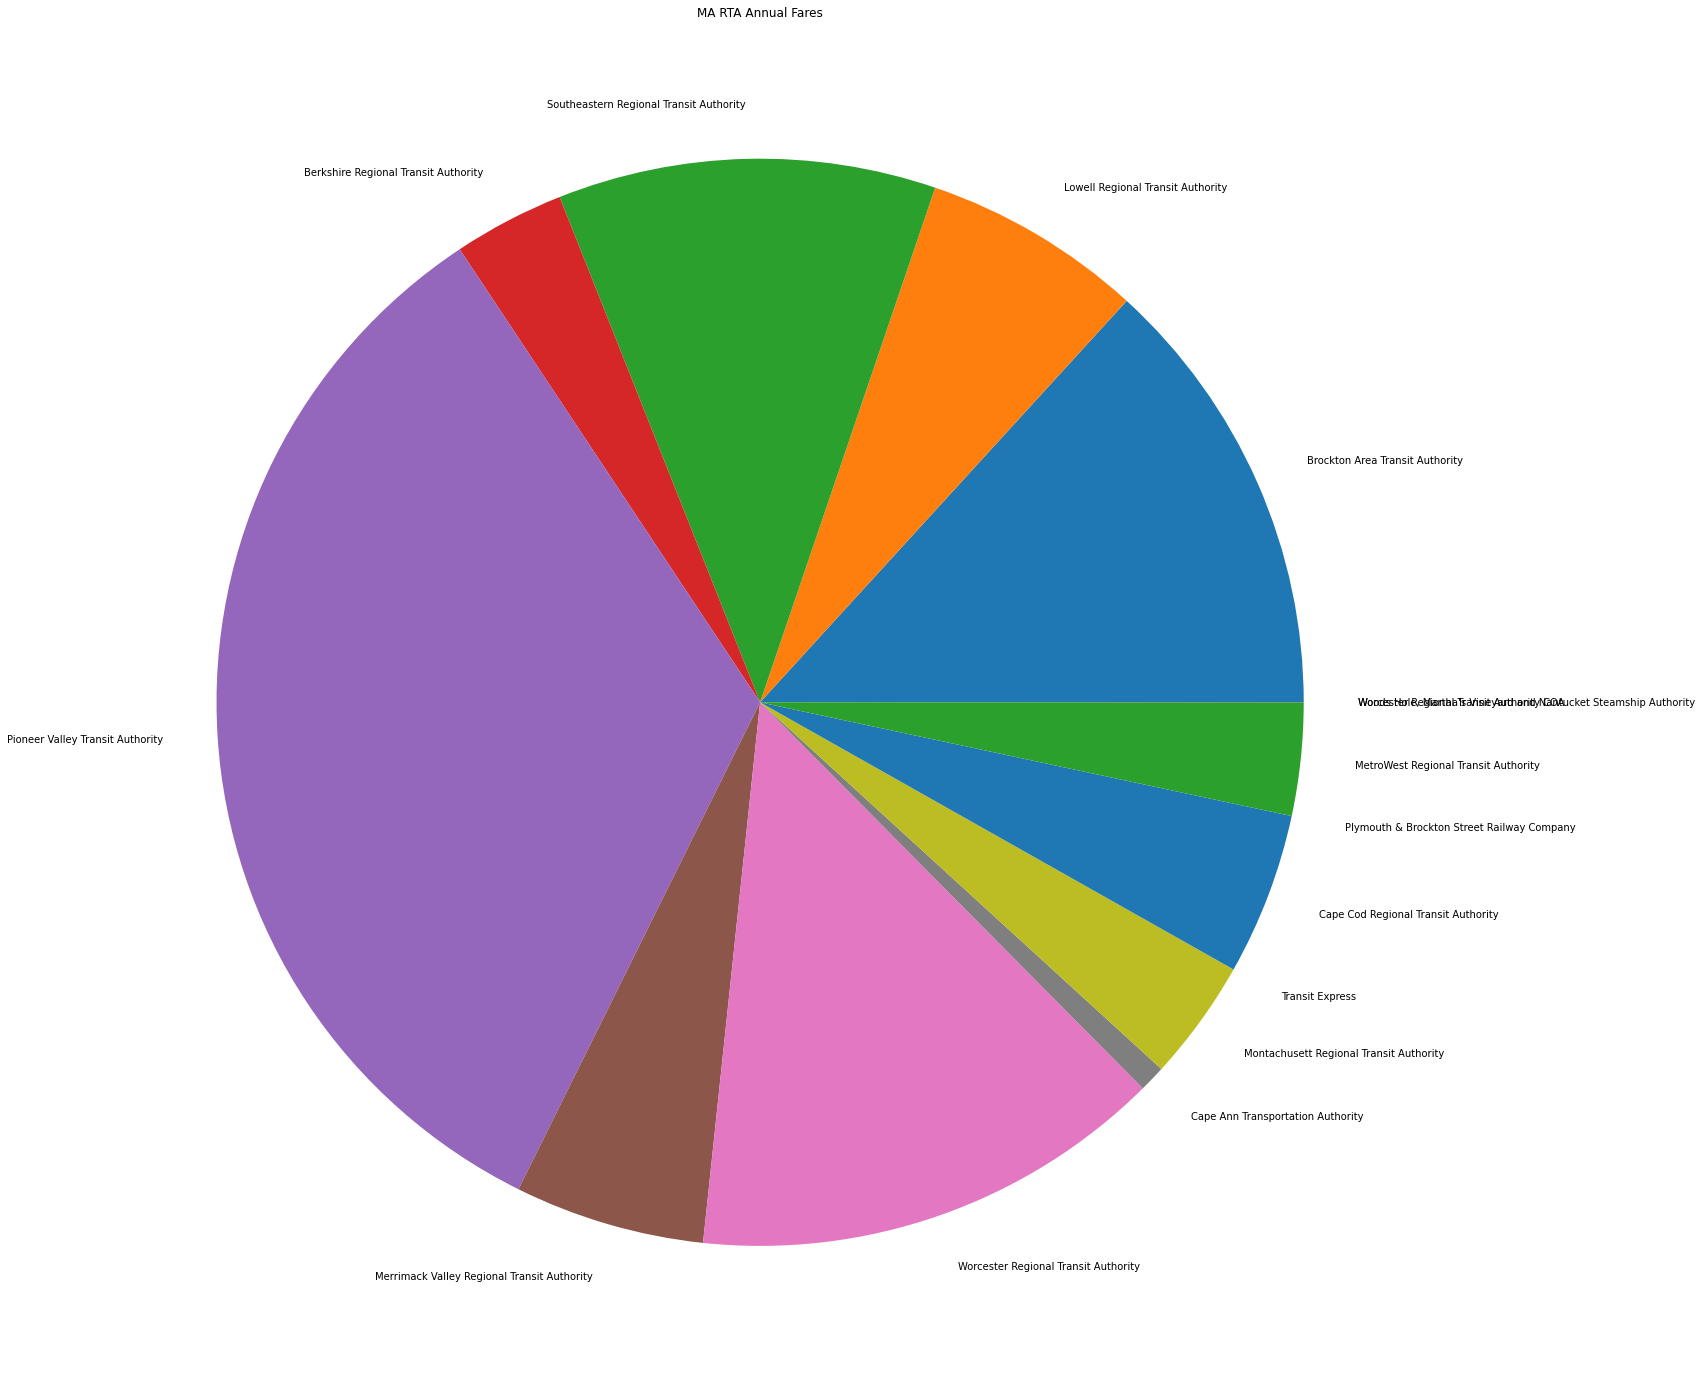

In [12]:
fig = plt.figure(figsize=(50,25))
plt.pie(agency_fares[['total fare']].to_numpy().flatten().astype(int), labels=agency_fares[['Agency']].to_numpy().flatten())
plt.title('MA RTA Annual Fares')
plt.show()

In [13]:
# Get only brockton
brockton = {
    'routes': route_df.loc[route_df['Agency'] == 'BrocktonAreaRTA'],
    'ridership': ridership_df.loc[ridership_df['Agency'] == 'Brockton Area Transit Authority'],
    'stops': [stop for stop in stops_data if stop['attributes']['Agency'] == 'BrocktonAreaRTA']
}

In [14]:
# save dataframes to csv
bus_area_income_df.to_csv('../data/bus_area_income_ma.csv')
route_df.to_csv('../data/rta_route_ma.csv')
ridership_df.to_csv('../data/rta_ridership_ma.csv')

# Strategic Q1
p = population census count of some bus stop

m = median household income of some bus stop

We defined the median household income of a route to be:
$$\frac{\sum p * m}{\sum p}$$

Where we are essentially normalizing the median household income of a route based on the stops along that route

In [15]:
route_names = list(set(result.route_long_name))

# TODO FIGURE OUT WHY WE HAVE DUPLICATE AGENCIES
# Normalize route's median household income by bus stops along the route
averages = {}
for route_name in tqdm(route_names):
    route_stops = result.loc[result.route_long_name == route_name]
    route_avg = (route_stops.population * route_stops.median_household_income).sum() / route_stops.population.sum()
    
    agencies = list(set(route_stops.Agency))
    averages[route_name] = {
        "median_household_income": float(route_avg), 
        "RTA": list(set(route_stops.Agency)),
        "route_population": float(route_stops.population.sum()),
        "short_name": list(set(route_stops.route_short_name))
    }


100%|██████████| 212/212 [00:01<00:00, 174.60it/s]


In [16]:
vals = list(averages.items())
poorest_routes = sorted(vals, key=lambda elem: elem[1]["median_household_income"])
print(f"Poorest routes:\n\n{json.dumps(poorest_routes[:5], indent=2)}")

Poorest routes:

[
  [
    "Olympia Dr / Atkins Corner",
    {
      "median_household_income": 10934.923766816144,
      "RTA": [
        "PioneerValleyRTA"
      ],
      "route_population": 11150.0,
      "short_name": [
        "36"
      ]
    }
  ],
  [
    "Plainfield Street",
    {
      "median_household_income": 17313.0,
      "RTA": [
        "PioneerValleyRTA"
      ],
      "route_population": 7000.0,
      "short_name": [
        "B4"
      ]
    }
  ],
  [
    "Spfld Plaza via Liberty/King-Westford",
    {
      "median_household_income": 27971.980582524273,
      "RTA": [
        "PioneerValleyRTA"
      ],
      "route_population": 20600.0,
      "short_name": [
        "G3"
      ]
    }
  ],
  [
    "North Amherst / Old Belchertown Rd",
    {
      "median_household_income": 30293.611940298506,
      "RTA": [
        "PioneerValleyRTA"
      ],
      "route_population": 6700.0,
      "short_name": [
        "30"
      ]
    }
  ],
  [
    "Broadway/UMass Lowell",
   

# Strategic Q2

C: Total Operating Cost

T: Total number of unlinked trips

F: Total fares in a fiscal year

Average Cost = $$\frac{C}{T}$$

Free Estimated Average Cost Per Trip = $$\frac{C + F}{T * 1.3}$$

We use the 1.3 constant due to the simpson curtson rule

In [17]:
RIDERSHIP_INCREASE_CONSTANT = 1.3

ridership_df['Free Estimated Average Cost Per Trip'] = \
    (ridership_df['Operating Expenses FY'] + ridership_df['Fares FY']) / \
    (ridership_df['Unlinked Passenger Trips FY'] * RIDERSHIP_INCREASE_CONSTANT)

ridership_df['Free percent average cost change'] = \
    (ridership_df['Free Estimated Average Cost Per Trip'] - ridership_df['Average Cost per Trip FY']) / \
    ridership_df['Average Cost per Trip FY']

In [19]:
display(ridership_df[[
    'Free Estimated Average Cost Per Trip',
    'Average Cost per Trip FY',
    'Free percent average cost change',
    'Agency'
]].sort_values('Free percent average cost change').dropna())

,Free Estimated Average Cost Per Trip,Average Cost per Trip FY,Free percent average cost change,Agency
270,5.843595,7.5967,-0.230772,"Woods Hole, Martha's Vineyard and Nantucket St..."
152,4.565229,5.8452,-0.218978,Massachusetts Bay Transportation Authority
261,38.680183,48.8760,-0.208606,Worcester Regional Transit Authority COA
170,6.272620,7.5696,-0.171341,Merrimack Valley Regional Transit Authority
201,7.516318,9.0034,-0.165169,Cape Ann Transportation Authority
217,9.408694,11.1007,-0.152423,Greater Attleboro-Taunton Regional Transit Aut...
257,7.948441,9.1898,-0.135080,MetroWest Regional Transit Authority
210,9.334594,10.7798,-0.134066,Montachusett Regional Transit Authority
165,9.223292,10.6482,-0.133817,Berkshire Regional Transit Authority
160,6.260449,7.1723,-0.127135,Lowell Regional Transit Authority


Below I will prove that assuming we have a 30% increase of ridership when we remove 100% of fares via the simpson curtson rule, average cost per trip will always decrease when the amount of revenue you generate is less than 3 tenths of the total operational cost:

I will define the below function to be the percent change of average cost per trip when you remove 100% of fares. Let's define the following variables:

x: Total revenue from fares

C: Total cost of operation

T: Total number of trips

$$g(x) = \frac{(\frac{c + x}{t*1.3}) - \frac{c}{t}}{\frac{c}{t}}$$

Notice this function will be strictly increasing when C and T are positive numbers.

Now to solve for when y=0:

$$0 = \frac{(\frac{c + x}{t*1.3}) - \frac{c}{t}}{\frac{c}{t}}$$

$$0 = \frac{c + x}{t*1.3} - \frac{c}{t}$$

$$\frac{c}{t} = \frac{c + x}{t*1.3}$$

$$c * 1.3 = c + x$$

$$c * 1.3 - c = x$$

$$.3 * c = x$$